# Detecting bullying Tweets with PyTorch LSTM + Attention and BERT Transformer Project

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


## Custom functions definition:

In [2]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [3]:
pip install langdetect

     |████████████████████████████████| 981 kB 11.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=75a410643b572843d8660ecfeb7a18719439e1e4d6f832e792c4e97f4fe6307c
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install contractions

     |████████████████████████████████| 101 kB 6.9 MB/s            
     |████████████████████████████████| 289 kB 32.5 MB/s            
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [5]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 432x288 with 0 Axes>

## Data Import

In [6]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [7]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [9]:
df = df.rename(columns={'tweet_text': 'tweet', 'cyberbullying_type': 'cyberbullying'})

# **2.Data Cleaning - Processing**

In [10]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

In [11]:
df = df.drop_duplicates()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          47656 non-null  object
 1   cyberbullying  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Are the classes balanced?

In [13]:
#check distribution
df.cyberbullying.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying, dtype: int64

Các categories khá balance


# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [14]:
# Clean emojis from text
def strip_emoji(text):
    '''Remove emoji'''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    '''Remove hashtag ở cuối câu. Thường hashtag cuối câu k có meaning. #popular event...
    Hashtags giữa câu thường nhấn mạnh'''
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
#def filter_chars(text):
    #return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
#def remove_mult_spaces(text):
    #return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    #tweet = filter_chars(tweet)
    #tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [15]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['tweet']]

In [16]:
df.head()

,tweet,cyberbullying,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [17]:
df['tweet'][3]

'@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.'

In [18]:
df['text_clean'][3]

'meh thanks head concerned another angry dude twitter'

In [19]:
#check duplicated agains
df.duplicated('text_clean').sum()

6249

In [20]:
df = df.drop_duplicates('text_clean')

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [21]:
#check cyberbullying after clean and drop duplicate
df.cyberbullying.value_counts()

religion               7913
age                    7817
ethnicity              7413
gender                 7278
not_cyberbullying      6075
other_cyberbullying    4911
Name: cyberbullying, dtype: int64

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [22]:
df = df[df["cyberbullying"]!="other_cyberbullying"]

In [23]:
#tính len của từng tweet
df['text_len'] = [len(text.split()) for text in df.text_clean]

In [24]:
df.head()

,tweet,cyberbullying,text_clean,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...,8


Then we also define a list of the classes names, which will be useful for the future plots.

In [25]:
df.sort_values(by=['text_len'], ascending=False)

,tweet,cyberbullying,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
6011,@glitchDreams @Popehat doesn't work. I don't t...,not_cyberbullying,work take request,3
673,My phones at 8% I'm going to cry.,not_cyberbullying,phone going cry,3
21319,@End_Bigotry @chezkig1 @edulixavot34 @georgega...,religion,as terrorist bitch,3
8445,#KellyFile #Hannity #TCOT,gender,kellyfile hannity tcot,3


In [26]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

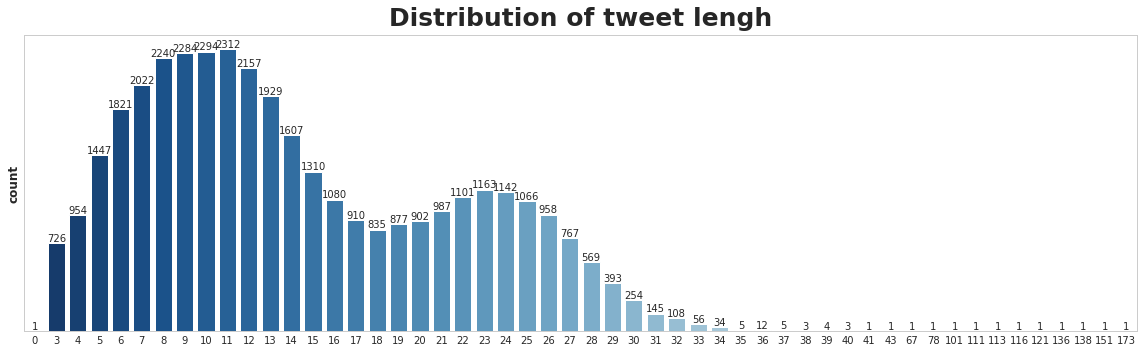

In [27]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000)], palette='Blues_r')
plt.title('Distribution of tweet lengh', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [28]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [29]:
df.sort_values(by=["text_len"], ascending=False)

,tweet,cyberbullying,text_clean,text_len
34752,How about if we got different girls on the bac...,age,got different girl bachelor show girl short ha...,31
36608,Getting paid on both sides. Bill G literally d...,age,getting paid side bill literally dismantled af...,31
17352,This exactly who the Far Right Radical MAGA Du...,religion,exactly far right radical maga dummy cherry pi...,31
20047,Only an idiot would expect to be treated kindl...,religion,idiot would expect treated kindly investing mu...,31
39110,My first day at a new high school -the boys be...,age,first day new high school boy behind lit hair ...,31
...,...,...,...,...
1960,Can tomatoes are fine #MKR,not_cyberbullying,tomato fine mkr,3
36133,Bully https://www.twitch.tv/jeffgamer55ryer @T...,age,bully old school,3
706,Uh. Why do they not make these for grownups? h...,not_cyberbullying,uh make grownup,3
5560,RT @Sir5000: @freebsdgirl Summer? But it's…hm....,not_cyberbullying,rt summer ishm,3


Then we also get the length of the longest tweet since it will be useful later.

In [30]:
max_len = np.max(df['text_len'])
max_len 

31

**Encoding Cyberbullying category**

In [31]:
df['cyberbullying'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4}, inplace = True)
df.cyberbullying.value_counts()


0    7834
1    7763
2    7354
3    7230
4    6072
Name: cyberbullying, dtype: int64

**- Religion: 0**

**- Age: 1**

**- Ethnicity: 2**

**- Gender: 3**

**- Not-cyberbullying: 4**


## Train - Test split

Now we need to split the dataset into a train and test sets.

In [120]:
#chia train, test với x = text_clean, y = cyberbullying, tỉ lẹ train-test: 8-2
X = df['text_clean']
y = df['cyberbullying']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [123]:
#check lại distribution của các categories
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4968],
       [   2, 4706],
       [   3, 4627],
       [   4, 3886]])

# Oversampling of training set

Vì các classes sau khi clean thì unbalance, nên dùng oversampleing lại tập train


In [124]:
sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_sampler = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'cyberbullying']);

In [125]:
X_train = train_sampler['text_clean'].values
y_train = train_sampler['cyberbullying'].values

In [126]:
#check lại distribution của các categories sau khi sample
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

# Naive Bayes baseline 


In [127]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [128]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [129]:
nb_clf = MultinomialNB()


In [130]:
nb_clf.fit(X_train_tf, y_train)


MultinomialNB()

In [131]:
nb_pred = nb_clf.predict(X_test_tf)


In [132]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.87      0.96      0.91      1567
         age       0.80      0.98      0.88      1553
   ethnicity       0.91      0.92      0.91      1471
      gender       0.88      0.86      0.87      1446
not bullying       0.82      0.48      0.60      1214

    accuracy                           0.86      7251
   macro avg       0.86      0.84      0.84      7251
weighted avg       0.86      0.86      0.85      7251



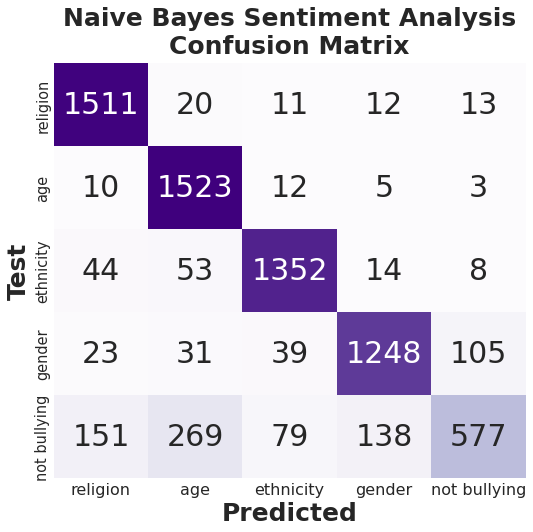

In [133]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

# PyTorch LSTM RNN w/ Attention

## Data preprocessing for LSTM

In [134]:
def Tokenize(column, seq_len):
    '''Chuyển đổi các word thành list và đếm số lượng'''
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()] #Tạo list từ vựng từ column text_clean
    count_words = Counter(corpus) # Đếm số lần xuất hiện của từng từ
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)} # mapping vocab thành int

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()] # Mã hóa văn bản thành các số nguyên dựa trên từ điển vocab
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)  # Tạo ma trận zeros để chứa kết quả cuối cùng
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review))) # Tạo padding bằng zeros
            new = zeros + review
        else:
            new = review[: seq_len]# Cắt các chuỗi quá dài
        features[i, :] = np.array(new) # Lưu kết quả vào ma trận cuối cùng

    return sorted_words, features

In [135]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [136]:
tokenized_column

array([[    0,     0,     0, ...,   563, 15535,    29],
       [    0,     0,     0, ...,  7697, 15538,   193],
       [    0,     0,     0, ...,   648,  9019,  5051],
       ...,
       [    0,     0,     0, ...,   427, 37562,     2],
       [    0,     0,     0, ...,    55,     9,     5],
       [    0,     0,     0, ...,     5,    24,   189]])

In [137]:
# vocabulary

In [138]:
df["text_clean"].iloc[0]

'word katandandre food crapilicious mkr'

This sentence is transformed to the vector:

In [139]:
tokenized_column[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,    85,  2152,   563, 15535,
          29])

Moreover we can also check the TOP 20 most common words by extracting them from the vocabulary python dictionary we created with the tokenizer.

In [140]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


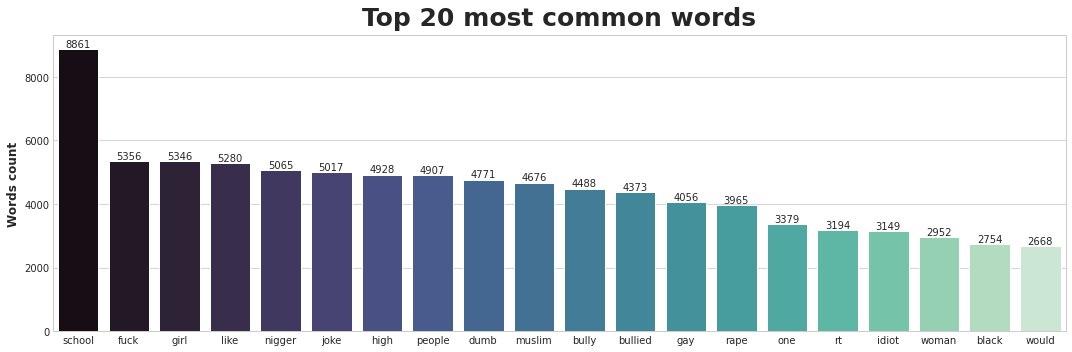

In [141]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

# Word Embedding by Word2Vec

Next, we will create a word embedding matrix using the original text tweets and the pre trained model Word2vec.<br>
First, we create a list of words from the X_train vector created before.

In [142]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

We set a dimension of the embedding words, which can be seen as the number of featurs of each transformed word.

In [143]:
EMBEDDING_DIM = 200

Then we can instaniate the Word2Vec model by passing the training words and chosen embedding dimension to the imported Word2vec object.

In [144]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

Before defining the embedding matrix, we also need to choose the max number of words. We will extract the number of words from the vocabulary python dictionary we created before.

In [145]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 37563


In [146]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

Finally we can define the embedding matrix.

In [147]:
# Define an empty embedding matrix of shape (VOCAB_SIZE, EMBEDDING_DIM)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Fill the embedding matrix with pre-trained values from word2vec
for word, token in vocabulary:
    # Check if the word is present in the word2vec model's vocabulary
    if word in word2vec_model.wv.key_to_index:
        # If the word is present, retrieve its embedding vector and add it to the embedding matrix
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[token] = embedding_vector

# Print the shape of the embedding matrix
print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (37563, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [148]:
#chia train_test_valid dùng tokenzied và cyberbullying
X = tokenized_column
y = df['cyberbullying'].values

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [151]:
# check lại balanced cho từng category
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 4968],
       [   2, 4706],
       [   3, 4627],
       [   4, 3886]])

In [152]:
# #sampling lại
sampler = RandomOverSampler()
X_train_os, y_train_os = sampler.fit_resample(np.array(X_train),np.array(y_train));

In [153]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

## PyTorch datasets and dataloaders

In [154]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [155]:
BATCH_SIZE = 32

In [156]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)


The Attention class defines our attention mechanism. This technique is commonly used in Natural Language Processing tasks to allow our model to focus on specific parts of the input sequence when generating output. It learns to assign weights to different parts of the input data, indicating their relevance. This class initializes an attention layer which takes into account whether our LSTM network is bidirectional or not.

In the Attention class forward method, we first calculate the attention weights. These weights are computed by applying a tanh activation function to the concatenated hidden states and encoder outputs. A softmax is then applied to the attention weights, ensuring they sum to 1 and hence can be interpreted as probabilities.

Next, we define our LSTM_Sentiment_Classifier class, which uses the Attention mechanism to make predictions. This class includes an LSTM network which takes embedded word representations as input and outputs hidden states. It also includes an attention layer, which uses these hidden states to compute attention weights and apply them to the encoder outputs to get a context vector. This context vector is passed through a fully connected layer followed by a log-softmax function to produce the final output probabilities.

In the forward method of LSTM_Sentiment_Classifier, we pass our inputs through an embedding layer, followed by the LSTM network. We then calculate the attention weights and form a context vector. This context vector serves as a summary of the entire input sequence, weighted by the attention mechanism's output. We pass this context vector through a fully connected layer and a log-softmax function to make our final prediction.

Lastly, we define a method init_hidden to initialize the hidden state of our LSTM network. Depending on whether our LSTM network is bidirectional or not, we may need to double the size of our hidden state.


In [157]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, is_bidirectional):
        super(Attention, self).__init__()
        self.is_bidirectional = is_bidirectional
        # The attention linear layer which transforms the input data to the hidden space
        self.attn = nn.Linear(hidden_dim * (4 if is_bidirectional else 2), hidden_dim * (2 if is_bidirectional else 1))
        # The linear layer that calculates the attention scores
        self.v = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        # Concatenate the last two hidden states in case of a bidirectional LSTM
        if self.is_bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=-1)
        else:
            hidden = hidden[-1]
        # Repeat the hidden state across the sequence length
        hidden_repeated = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Calculate attention weights
        attn_weights = torch.tanh(self.attn(torch.cat((hidden_repeated, encoder_outputs), dim=2)))
        # Compute attention scores
        attn_weights = self.v(attn_weights).squeeze(2)
        # Apply softmax to get valid probabilities
        return nn.functional.softmax(attn_weights, dim=1)


class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

#         The Embedding layer that converts input words to embeddings
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer which processes the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        # Attention layer to compute the context vector
        self.attention = Attention(hidden_dim, is_bidirectional)
        # Fully connected layer which classifies the context vector into classes
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        # Apply LogSoftmax to outputs for numerical stability
        self.softmax = nn.LogSoftmax(dim=1)
        # Dropout layer for regularisation
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        # Transform words to embeddings
        embedded = self.embedding(x)
        # Pass embeddings to LSTM
        out, hidden = self.lstm(embedded, hidden)
        # Calculate attention weights
        attn_weights = self.attention(hidden[0], out)
        # Calculate context vector by taking the weighted sum of LSTM outputs
        context = attn_weights.unsqueeze(1).bmm(out).squeeze(1)
        # Classify the context vector
        out = self.softmax(self.fc(context))
        return out, hidden

    def init_hidden(self, batch_size):
        # Factor determines the size of hidden states depending on bidirectionality
        factor = 2 if self.is_bidirectional else 1
        # Initial hidden and cell states are zero
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)

In [158]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

IS_BIDIRECTIONAL = False # Set this to False for unidirectional LSTM, and True for bidirectional LSTM

LR = 4e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
EPOCHS = 10 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)

model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
# Allow the embedding matrix to be fine-tuned to better adapt to our dataset and get higher accuracy
model.embedding.weight.requires_grad = True

# Set up the criterion (loss function)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(37563, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (attention): Attention(
    (attn): Linear(in_features=200, out_features=100, bias=True)
    (v): Linear(in_features=100, out_features=1, bias=False)
  )
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.5, inplace=False)
)


# LSTM Training loop 

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [159]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 91.799033).  Saving model ...
	Train_loss : 0.6833 Val_loss : 0.2437
	Train_acc : 71.811% Val_acc : 91.799%
Epoch 2:Validation accuracy increased (91.799033 --> 92.904006).  Saving model ...
	Train_loss : 0.1878 Val_loss : 0.2101
	Train_acc : 93.774% Val_acc : 92.904%
Epoch 3:Validation accuracy did not increase
	Train_loss : 0.1061 Val_loss : 0.2170
	Train_acc : 96.508% Val_acc : 92.662%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0621 Val_loss : 0.2896
	Train_acc : 98.156% Val_acc : 91.005%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0385 Val_loss : 0.2934
	Train_acc : 98.894% Val_acc : 91.678%
Epoch 6:Validation accuracy did not increase
	Train_loss : 0.0283 Val_loss : 0.3227
	Train_acc : 99.230% Val_acc : 91.471%
Epoch 7:Validation accuracy did not increase
Early stopped at epoch : 7


In [160]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

# LSTM Testing

In [161]:
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

In [162]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.95      0.96      0.96      1560
         age       0.99      0.96      0.97      1552
   ethnicity       0.98      0.97      0.98      1466
      gender       0.96      0.85      0.90      1444
not bullying       0.78      0.90      0.84      1210

    accuracy                           0.93      7232
   macro avg       0.93      0.93      0.93      7232
weighted avg       0.94      0.93      0.93      7232



In [163]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

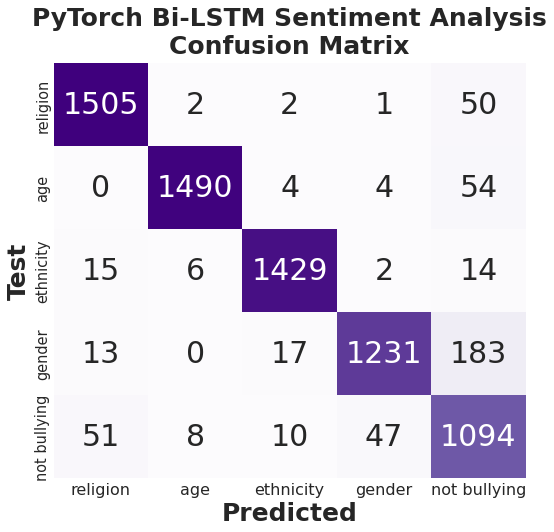

In [164]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

The performance scores of the algorithm are very high, with an overall accuracy of 93%.

In particular, the F1 scores for the more populated classes are over 95%

# BERT Classification - Preparing

## Train - Validation - Test split

In [165]:
#chia train_test
X = df['text_clean'].values
y = df['cyberbullying'].values

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [168]:
#sampling lại train_test
sampler = RandomOverSampler()
X_train_os_0, y_train_os_0 = sampler.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [169]:
X_train_os = X_train_os_0.flatten()#chuyển về mảng 1 chiều
y_train_os = y_train_os_0.flatten()

In [170]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5014],
       [   1, 5014],
       [   2, 5014],
       [   3, 5014],
       [   4, 5014]])

# BERT Tokenization

 mã hóa các tweet (nhận "input ids" and "attention masks") cho BERT

In [171]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Then we define a custom tokenizer function using the loaded tokenizer.

In [172]:
def bert_tokenizer(data):
    input_ids = [] # Tạo danh sách rỗng để chứa các input_ids
    attention_masks = [] # Tạo danh sách rỗng để chứa các attention_masks
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,# Mã hoá câu input
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        # Lấy các input_ids và attention_masks từ kết quả encode_plus và thêm vào danh sách tương ứng
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    #Chuyển danh sách thành tensors (tensor là cấu trúc dữ liệu giống mảng đa chiều)
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [173]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


We can choose the max length as 128.

In [174]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [175]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [176]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

DATALOADER

In [177]:
batch_size = 32

In [178]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [179]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [180]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [181]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [182]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# TRAINING MODEL

In [183]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [184]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.610508   |   39.24  
   200    |   0.284367   |   38.77  
   300    |   0.242579   |   38.70  
   400    |   0.229575   |   38.71  
   500    |   0.233150   |   38.78  
   600    |   0.210625   |   38.69  
   700    |   0.185742   |   38.67  
   783    |   0.181790   |   31.90  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.274686    |  0.191196  |       94.24       |  325.67  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.134463   |   39.08  
   200    |   0.124667   |   38.67  
   3

# PREDICTION"

In [185]:
def bert_predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

In [186]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [187]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.97      0.97      0.97      1567
         age       0.99      0.98      0.99      1553
   ethnicity       0.99      0.99      0.99      1471
      gender       0.93      0.91      0.92      1446
not bullying       0.83      0.88      0.86      1214

    accuracy                           0.95      7251
   macro avg       0.94      0.94      0.94      7251
weighted avg       0.95      0.95      0.95      7251



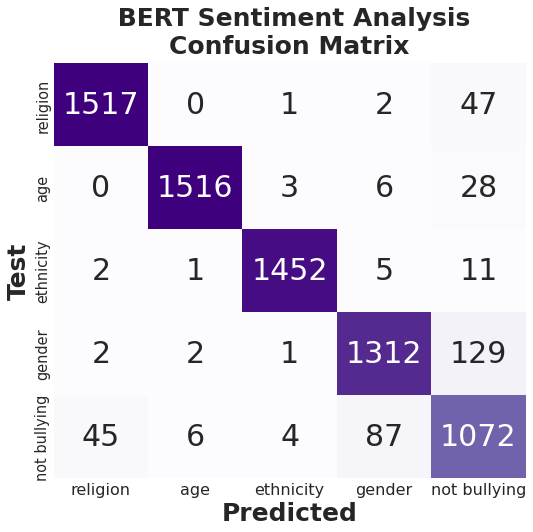

In [188]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

# COMPARE PERFORMANCE

Metrics:

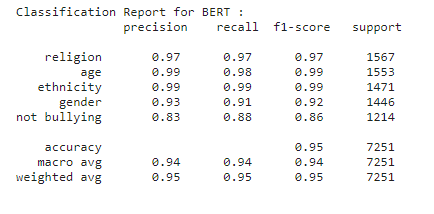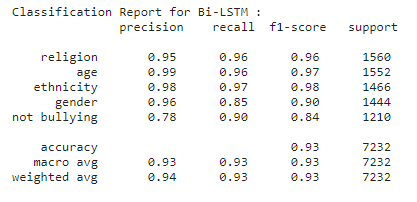

Confusion matrix

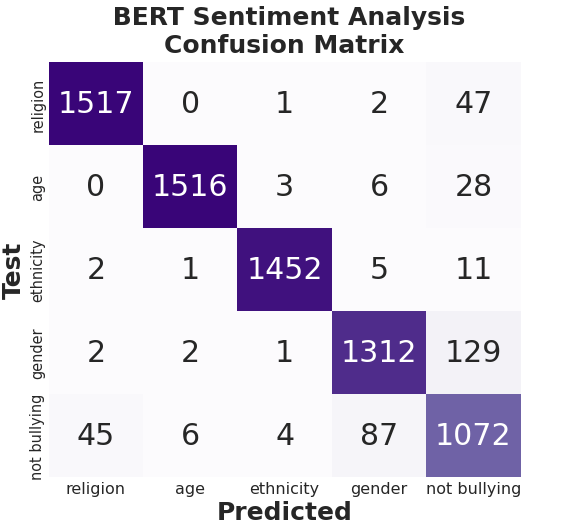 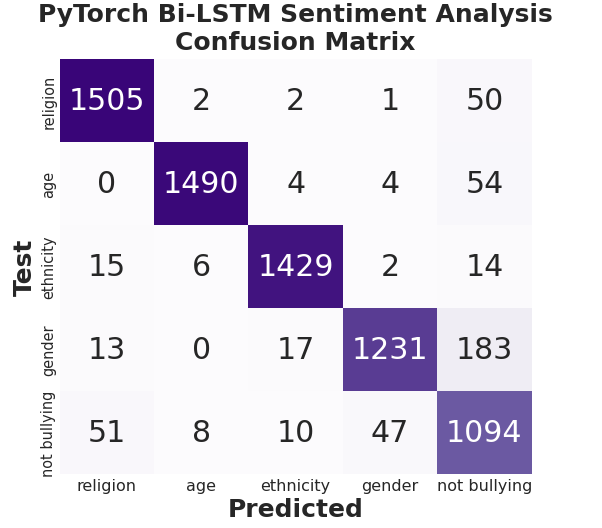

The performance scores of BERT Classifier are quite high and higher than those achieved using the LSTM model, with an overall accuracy around 95% and F1 scores well over 95%.

**In general, BERT is better than Bi-LSTM in almost metrics. \
Recall - the most important metric are higher in every class.**